In [60]:
# Initialize Otter
import otter
grader = otter.Notebook("HW_3_robot_arm.ipynb")

# Robot arm

Part 1: Forward kinematics

Part 2: Optimization

Slides: https://docs.google.com/presentation/d/17aiTBmPZidR6op7TvqYRzYatuc_NETYA1BhgpSHQ-FM/edit?usp=sharing

In [61]:
# The usual imports
import numpy as np
import matplotlib.pyplot as plt

# These are the routines used in the lab and/or you need to fill in for the homework (lab 5, week 5)
from object_routines import plot_object_in_world_coord_system, plot_object_in_own_coord_system
from arm_routines import get_matrices_all_links, create_arm_geometry, set_angles_of_arm_geometry, \
                         plot_complete_arm, get_gripper_location, get_matrix_base


In [62]:
# This bit of code tells Jupyter notebooks to also look in the week_6_optimization folder for files
import os
import sys
sys.path.insert(0, os.path.abspath('../Week_7_optimization'))

# These are the routines used in the lab and/or you need to fill in for the homework (lab 6, week 6)
from arm_optimization_routines import distance_to_goal, do_fmin

In [63]:
# These commands will force JN to actually re-load the external file when you re-execute the import command
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Doing forward kinematics

TODO: Edit the step 3 functions in arm_routines.py (get_matrix_base, get_matrix_link, get_matrices_all_links)

The three functions build the matrices you need to move each component to the end of the previous one. There's a "special" one for figuring out how to place the start of the arm on the base. For every other link the calculation for the matrix is the same. The third function does the for loops that call the second function for each link.

In [64]:
    # Create the arm geometry (done in Lab 5)
    base_size_param = (1.0, 0.5)
    link_sizes_param = [(0.5, 0.25), (0.3, 0.1), (0.2, 0.05)]
    palm_width_param = 0.1
    finger_size_param = (0.075, 0.025)


    # This function calls each of the set_transform_xxx functions, and puts the results
    # in a list (the gripper - the last element - is a list)
    arm_geometry = create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

In [65]:
## Check the combined link/gripper/finger rotations
# Several different angles to check your routines with 
# Pass the one you want to check into set_angles_of_arm_geometry below
angles_none = [0.0, 0.0, 0.0, [0.0, 0.0, 0.0]]
angles_check_link_0 = [np.pi/4, 0.0, 0.0, [0.0, 0.0, 0.0]]
angles_check_link_0_1 = [np.pi/4, -np.pi/4, 0.0, [0.0, 0.0, 0.0]]
angles_check_wrist = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [np.pi/3.0, 0.0, 0.0]]
angles_check_fingers = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [0.0, np.pi/4.0, -np.pi/4.0]]

Angle rotated by 1.5707963267948966


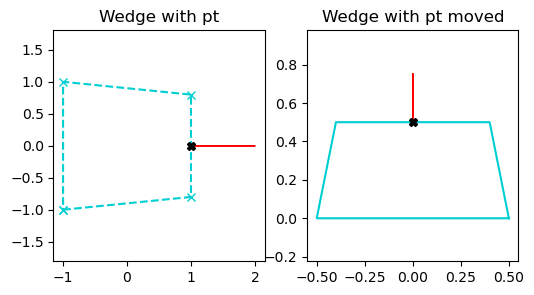

In [66]:
# EXAMPLE CODE
# Getting out where the base of the matrix is and what rotation to use.

# This is the matrix that transforms the base
#  The first item in the arm geometry list is the base
matrix_base = arm_geometry[0]["Matrix"]

# Draw the wedge in it's original location, with the point we're interested in (and direction)
pt_on_top = np.array([1, 0, 1]).transpose()
vec_on_top = np.array([1, 0, 0]).transpose()
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].set_title("Wedge with pt")
plot_object_in_own_coord_system(axs[0], arm_geometry[0])
axs[0].plot(pt_on_top[0], pt_on_top[1], 'Xk')
axs[0].arrow(x=pt_on_top[0], y=pt_on_top[1], dx=vec_on_top[0], dy=vec_on_top[1], color="red")

# Multiply the point and the vector by the matrix base's matrix
pt_on_top_moved = matrix_base @ pt_on_top
vec_on_top_moved = matrix_base @ vec_on_top
axs[1].set_title("Wedge with pt moved")
plot_object_in_world_coord_system(axs[1], arm_geometry[0], np.identity(3))
axs[1].plot(pt_on_top_moved[0], pt_on_top_moved[1], 'Xk')
axs[1].arrow(x=pt_on_top_moved[0], y=pt_on_top_moved[1], dx=vec_on_top_moved[0], dy=vec_on_top_moved[1], color="red")

# arctan2 gets the arc tangent of the y, x, and correctly handles the quadrants
angle_of_rotation = np.arctan2(vec_on_top_moved[1], vec_on_top_moved[0])

print(f"Angle rotated by {angle_of_rotation}")

In [67]:
# Use this cell to debug get_matrices_all_links. 
#  get_matrices_all_links calls get_matrix_base(arm_with_angles[0]))
set_angles_of_arm_geometry(arm_geometry, angles_none)

# get_matrices_all_links will call get_matrix_base with the first item in the arm_geometry list
mat_from_base = get_matrix_base(arm_geometry[0])

matrices = get_matrices_all_links(arm_geometry)



In [68]:
# Use this cell to visually check the results
# With angles_none it should point straight up
# If you do NOT have the gripper function done, this will not show the green + (see next question)
matrices = get_matrices_all_links(arm_geometry)

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plot_complete_arm(axs, arm_geometry, matrices)

(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
[[ 6.12323400e-17 -1.00000000e+00  7.65404249e-17]
 [ 1.00000000e+00  6.12323400e-17  1.50000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 6.12323400e-17 -1.00000000e+00  7.65404249e-17]
 [ 1.00000000e+00  6.12323400e-17  1.50000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[7.99847441e-17 1.55625000e+00 1.00000000e+00]


In [69]:
# Don't change this one
angles_check = [np.pi/2, -np.pi/4, -3.0 * np.pi/4, [np.pi/3.0, np.pi/4.0, -np.pi/4.0]]
set_angles_of_arm_geometry(arm_geometry, angles_check)
matrices = get_matrices_all_links(arm_geometry)
print(matrices)

[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[ 6.1232340e-17, -1.0000000e+00,  1.5308085e-17],
       [ 1.0000000e+00,  6.1232340e-17,  5.0000000e-01],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]), array([[-1.0000000e+00, -1.2246468e-16, -5.0000000e-01],
       [ 1.2246468e-16, -1.0000000e+00,  5.0000000e-01],
       [ 0.0000000e+00,  0.0000000e+00,  1.0000000e+00]]), array([[-0.70710678, -0.70710678, -0.71213203],
       [ 0.70710678, -0.70710678,  0.71213203],
       [ 0.        ,  0.        ,  1.        ]]), array([[ 1.00000000e+00,  1.11022302e-16, -5.12132034e-01],
       [-1.11022302e-16,  1.00000000e+00,  7.12132034e-01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])]


In [70]:
mat_check_base = np.identity(3)
assert(np.all(np.isclose(matrices[0], mat_check_base, atol=0.01)))

In [71]:
mat_check_link_1 = np.array([[ 0.0, -1.0,  0.0], \
                             [ 1.0,  0.0,  0.5], \
                             [ 0.0,  0.0,  1.0]])
assert(np.all(np.isclose(matrices[1], mat_check_link_1, atol=0.01)))

In [72]:
mat_check_link_2 = np.array([[ -1.0, 0.0,  -0.5], \
                             [ 0.0,  -1.0,  0.5], \
                             [ 0.0,  0.0,  1.0]])
assert(np.all(np.isclose(matrices[2], mat_check_link_2, atol=0.01)))

In [73]:
mat_check_wrist = np.array([[ 1.0, 0.0,  -0.5121], \
                            [ 0.0, 1.0,   0.7121], \
                            [ 0.0,  0.0,  1.0]])
assert(np.all(np.isclose(matrices[-1], mat_check_wrist, atol=0.01)))

In [74]:
grader.check("step3")

step3 results: All test cases passed!

# Gripper location

TODO: edit get_gripper_location to return the x,y location of the gripper.

A reminder that the grasp location is offset from the palm by a bit (["grasp"] key in palm object)

(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
[[-0.8660254   0.5        -0.75621778]
 [-0.5        -0.8660254   0.90980762]
 [ 0.          0.          1.        ]]
[[-0.96592583 -0.25881905 -0.75621778]
 [ 0.25881905 -0.96592583  0.90980762]
 [ 0.          0.          1.        ]]
[-0.81055111  0.92436619  1.        ]


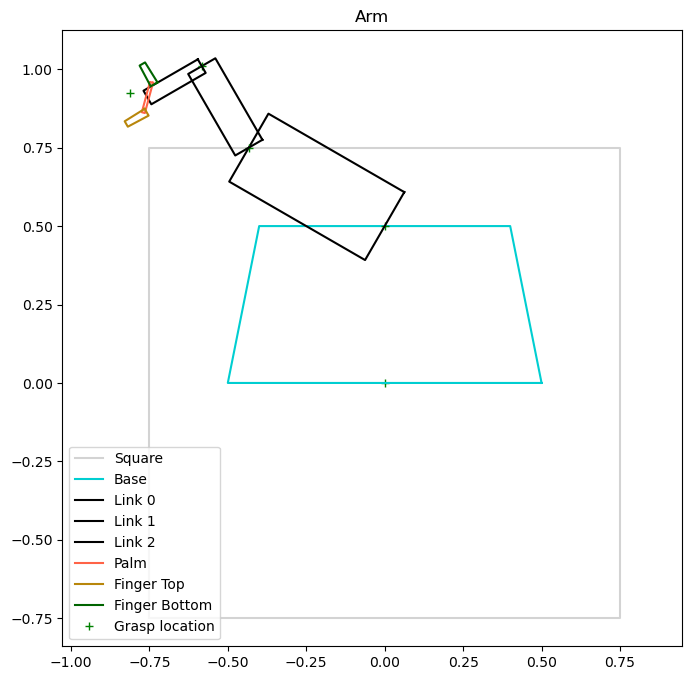

In [75]:
# Check the gripper function
# As in the previous problem, you can use the "simpler" angles to check your function
angles_gripper_check = [np.pi/3, -np.pi/6, 3.0 * np.pi/6, [-np.pi/4, np.pi/4.0, -np.pi/4.0]]

# Actually set the matrices
set_angles_of_arm_geometry(arm_geometry, angles_gripper_check)
matrices = get_matrices_all_links(arm_geometry)

# Now actually plot - the grasper grip location should show up as a green cross
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_geometry, matrices)

(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
[[-0.8660254   0.5        -0.75621778]
 [-0.5        -0.8660254   0.90980762]
 [ 0.          0.          1.        ]]
[[-0.96592583 -0.25881905 -0.75621778]
 [ 0.25881905 -0.96592583  0.90980762]
 [ 0.          0.          1.        ]]
[-0.81055111  0.92436619  1.        ]


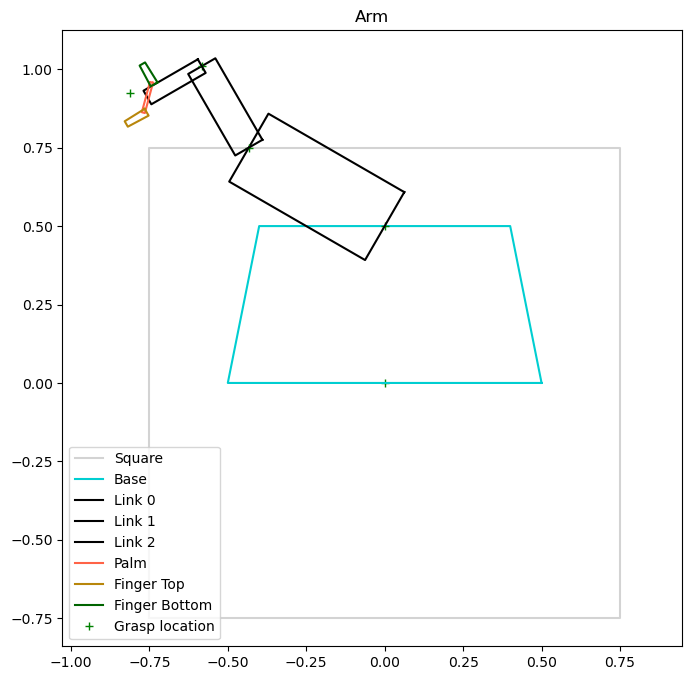

In [76]:
# Now actually plot - the grasper grip location should show up as a green cross
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_geometry, matrices)

In [77]:
# Numerical check - don't change these
set_angles_of_arm_geometry(arm_geometry, angles_gripper_check)

grasp_loc = get_gripper_location(arm_geometry)
print(f"Grasp loc is {grasp_loc}, expected (-0.8106, 0.92437)")
assert(np.isclose(grasp_loc[0], -0.8106, atol=0.01) and np.isclose(grasp_loc[1], 0.92437, atol=0.01))

[[-0.8660254   0.5        -0.75621778]
 [-0.5        -0.8660254   0.90980762]
 [ 0.          0.          1.        ]]
[[-0.96592583 -0.25881905 -0.75621778]
 [ 0.25881905 -0.96592583  0.90980762]
 [ 0.          0.          1.        ]]
[-0.81055111  0.92436619  1.        ]
Grasp loc is (-0.8105511103778672, 0.9243661924223483), expected (-0.8106, 0.92437)


In [78]:
grader.check("gripper_loc")

gripper_loc results: All test cases passed!

# FMin optimization

Note: func_for_fmin from the Lab should be working first

TODO: Edit do_fmin to call func_for_fmin with the appropriate angles, etc


In [79]:
# Set the starting angles of the arm
#. Note: It really shouldn't matter what these are for the final result, as long as they're "reasonable"
angles_start = [np.pi/6.0, -np.pi/4, 1.5 * np.pi/4, [np.pi/3.0, -np.pi/8.0, np.pi/6.0]]
set_angles_of_arm_geometry(arm_geometry, angles_start)

# Do the optimization
target = np.array([0.55, 1.15])
angles_optimized = do_fmin(angles_start, arm_geometry, target)

# Make sure the angles of the arm are set to the optimized one
set_angles_of_arm_geometry(arm_geometry, angles_optimized)

# Check that this is close to zero
d_to_target = distance_to_goal(arm_geometry, target)
print(f"Distance to goal {d_to_target}, should be close to zero if target reachable")

assert(np.isclose(d_to_target, 0.0, atol=0.01))

[[-0.79335334 -0.60876143 -0.33102495]
 [ 0.60876143 -0.79335334  1.34454274]
 [ 0.          0.          1.        ]]
[[-0.92387953  0.38268343 -0.33102495]
 [-0.38268343 -0.92387953  1.34454274]
 [ 0.          0.          1.        ]]
[-0.38299318  1.32301679  1.        ]
end_pt: (-0.38299317823125056, 1.3230167925101477)


TypeError: 'int' object is not subscriptable

(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
(0.0, 0.0)
[0.0375 0.0125 1.    ]
(0.0, 0.0)
[[ 0.37341384 -0.92766487  0.60364952]
 [ 0.92766487  0.37341384  1.13310212]
 [ 0.          0.          1.        ]]
[[-0.95381788 -0.30038552  0.60364952]
 [ 0.30038552 -0.95381788  1.13310212]
 [ 0.          0.          1.        ]]
[0.54999726 1.1499988  1.        ]


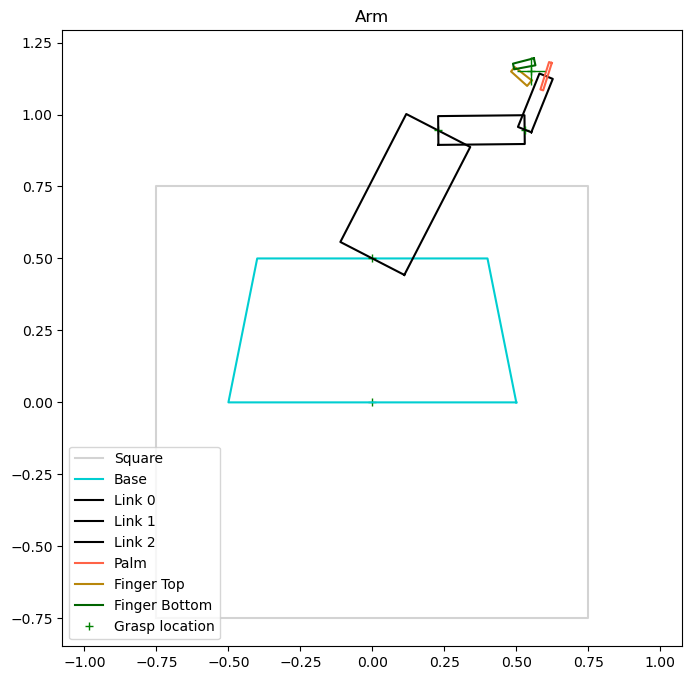

In [ ]:
# Plot arm with target
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_geometry, get_matrices_all_links(arm_geometry))
axs.plot(target[0], target[1], '+g', markersize=20)

In [ ]:
grader.check("optimization")

optimization results: All test cases passed!

# Generalization

If nothing has been "hardwired" in, this should just work - changing the geometry, the starting angles, the target point. However, if you've hardwired something in, it probably won't...

In [ ]:
# Create the arm geometry
base_size_param = (0.5, 0.25) # squished
link_sizes_param = [(0.3, 0.15), (0.2, 0.09), (0.1, 0.05), (0.075, 0.03)]
palm_width_param = 0.15
finger_size_param = (0.085, 0.015)


# This function calls each of the set_transform_xxx functions, and puts the results
# in a list (the gripper - the last element - is a list)
arm_longer = create_arm_geometry(base_size_param, link_sizes_param, palm_width_param, finger_size_param)

# Set the angles of the arm
angles_start = [-np.pi/4.0, -np.pi/4, 1.2 * np.pi/4, -1 * np.pi/8, [-np.pi/3.0, np.pi/6.0, -np.pi/6.0]]
set_angles_of_arm_geometry(arm_longer, angles_start)

target_longer = np.array([0.3, -0.25])

(0.0, 0.0)
[0.0425 0.0075 1.    ]
(0.0, 0.0)
(0.0, 0.0)
[0.0425 0.0075 1.    ]
(0.0, 0.0)
[[ 0.85264016 -0.52249856  0.53485857]
 [ 0.52249856  0.85264016  0.58222113]
 [ 0.          0.          1.        ]]
[[ 0.87881711  0.47715876  0.53485857]
 [-0.47715876  0.87881711  0.58222113]
 [ 0.          0.          1.        ]]
[0.59088316 0.55180226 1.        ]


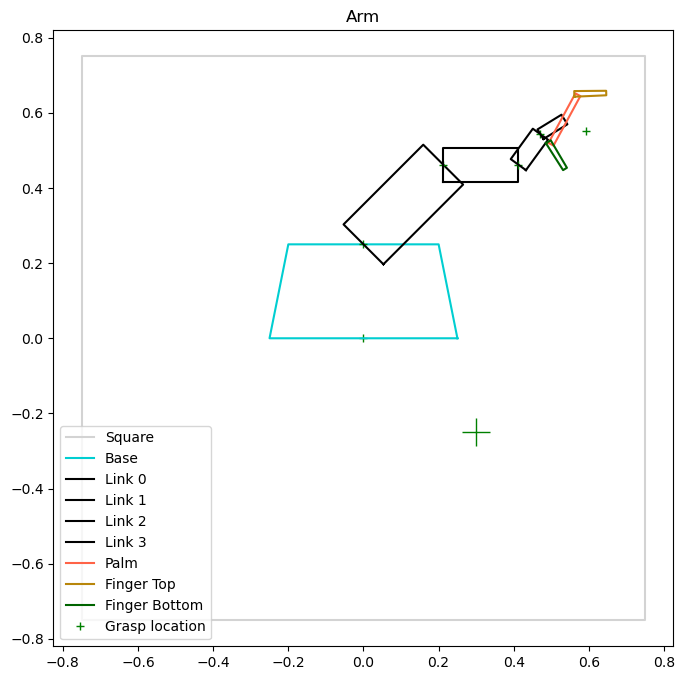

In [ ]:
# Plot arm with target
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_longer, get_matrices_all_links(arm_longer))
axs.plot(target_longer[0], target_longer[1], '+g', markersize=20)

In [ ]:
# Do the optimization
angles_optimized = do_fmin(angles_start, arm_longer, target_longer)
set_angles_of_arm_geometry(arm_longer, angles_optimized)

[[ 0.85264016 -0.52249856  0.53485857]
 [ 0.52249856  0.85264016  0.58222113]
 [ 0.          0.          1.        ]]
[[ 0.87881711  0.47715876  0.53485857]
 [-0.47715876  0.87881711  0.58222113]
 [ 0.          0.          1.        ]]
[0.59088316 0.55180226 1.        ]
end_pt: (0.5908831628439689, 0.5518022551806052)
[[ 0.87249601 -0.48862124  0.54748916]
 [ 0.48862124  0.87249601  0.56096655]
 [ 0.          0.          1.        ]]
[[ 0.85940641  0.51129309  0.54748916]
 [-0.51129309  0.85940641  0.56096655]
 [ 0.          0.          1.        ]]
[0.60227631 0.52837161 1.        ]
end_pt: (0.6022763142735111, 0.5283716124710028)
[[ 0.87249601 -0.48862124  0.53932444]
 [ 0.48862124  0.87249601  0.56945836]
 [ 0.          0.          1.        ]]
[[ 0.85940641  0.51129309  0.53932444]
 [-0.51129309  0.85940641  0.56945836]
 [ 0.          0.          1.        ]]
[0.5941116  0.53686342 1.        ]
end_pt: (0.5941115957987697, 0.5368634231670846)
[[ 0.82708057 -0.56208338  0.52906536]
 

In [80]:
# Plot arm with target
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
plot_complete_arm(axs, arm_longer, get_matrices_all_links(arm_longer))
axs.plot(target_longer[0], target_longer[1], '+g', markersize=20)

(0.0, 0.0)
[0.0425 0.0075 1.    ]
(0.0, 0.0)
(0.0, 0.0)
[0.0425 0.0075 1.    ]
(0.0, 0.0)
[[ 0.23728201  0.97144081  0.3205339 ]
 [-0.97144081  0.23728201 -0.18964336]
 [ 0.          0.          1.        ]]
[[-0.3220282   0.94673008  0.3205339 ]
 [-0.94673008 -0.3220282  -0.18964336]
 [ 0.          0.          1.        ]]
[ 0.30000461 -0.24999741  1.        ]


In [100]:
assert(np.isclose(distance_to_goal(arm_longer, target_longer), 0.0, atol=0.01))
somesing = distance_to_goal(arm_longer, target_longer)
print(somesing)

[[ 0.23728201  0.97144081  0.3205339 ]
 [-0.97144081  0.23728201 -0.18964336]
 [ 0.          0.          1.        ]]
[[-0.3220282   0.94673008  0.3205339 ]
 [-0.94673008 -0.3220282  -0.18964336]
 [ 0.          0.          1.        ]]
[ 0.30000461 -0.24999741  1.        ]
end_pt: (0.3000046073081751, -0.24999740620448577)
target: [ 0.3  -0.25]
[[ 0.23728201  0.97144081  0.3205339 ]
 [-0.97144081  0.23728201 -0.18964336]
 [ 0.          0.          1.        ]]
[[-0.3220282   0.94673008  0.3205339 ]
 [-0.94673008 -0.3220282  -0.18964336]
 [ 0.          0.          1.        ]]
[ 0.30000461 -0.24999741  1.        ]
end_pt: (0.3000046073081751, -0.24999740620448577)
target: [ 0.3  -0.25]
5.287254844422849e-06


In [97]:
grader.check("generalization")

generalization results:
    generalization - 1 result:
        ❌ Test case failed
        Trying:
            assert(np.isclose(distance_to_goal(arm_geometry, target), 0.0, atol=0.01))
        Expecting nothing
        **********************************************************************
        Line 1, in generalization 0
        Failed example:
            assert(np.isclose(distance_to_goal(arm_geometry, target), 0.0, atol=0.01))
        Exception raised:
            Traceback (most recent call last):
              File "c:\Users\yeasshhhh\anaconda3\Lib\doctest.py", line 1351, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest generalization 0[0]>", line 1, in <module>
                assert(np.isclose(distance_to_goal(arm_geometry, target), 0.0, atol=0.01))
            AssertionError

## Hours and collaborators
Required for every assignment - fill out before you hand-in.

Listing names and websites helps you to document who you worked with and what internet help you received in the case of any plagiarism issues. You should list names of anyone (in class or not) who has substantially helped you with an assignment - or anyone you have *helped*. You do not need to list TAs.

Listing hours helps us track if the assignments are too long.

In [ ]:

# List of names (creates a set)
worked_with_names = {"none"}
# List of URLS TCW3 (creates a set)
websites = {"none"}
# Approximate number of hours, including lab/in-class time
hours = 2

In [ ]:
grader.check("hours_collaborators")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

Submit through gradescope, HWK 3 Robot arm

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)